In [1]:
import os,sys
import numpy as np
import scipy as sp
import pandas as pd
import tensorflow as tf 
import matplotlib as mlt
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib import animation
sys.path.append("../src")  # adjust path as needed
from data_generator import data_generator
from model import pinn_models
from tensorflow.keras import models
from matplotlib.animation import FuncAnimation


### Load the data for ML model and train the model

In [2]:
data_dir = '/Users/pushpita/Documents/ML Projects/Project3/data/csv_files/diffusion0.1/'
D = 0.1

model_ini = pinn_models(data_dir, resolution=100, N_IC=100, N_BC=100, N_CP=100, epoch=3000)
model = model_ini.build_pinnmodel_single()
model_ini.train_model_single(diff_const=D)


Epoch 0: Total Loss = 5.8169e-01 | IC = 5.7028e-01 | BC = 3.3675e-03 | PDE = 8.0382e-03
Epoch 100: Total Loss = 6.8949e-02 | IC = 2.5111e-02 | BC = 1.3280e-02 | PDE = 3.0559e-02
Epoch 200: Total Loss = 3.7245e-03 | IC = 1.1887e-03 | BC = 6.4669e-04 | PDE = 1.8891e-03
Epoch 300: Total Loss = 1.5191e-03 | IC = 4.7021e-04 | BC = 5.8672e-04 | PDE = 4.6220e-04
Epoch 400: Total Loss = 9.9279e-04 | IC = 3.7929e-04 | BC = 3.8673e-04 | PDE = 2.2678e-04
Epoch 500: Total Loss = 8.6614e-04 | IC = 2.3013e-04 | BC = 3.8895e-04 | PDE = 2.4706e-04
Epoch 600: Total Loss = 8.2082e-04 | IC = 2.0377e-04 | BC = 3.6877e-04 | PDE = 2.4829e-04
Epoch 700: Total Loss = 7.0228e-04 | IC = 1.5024e-04 | BC = 2.7407e-04 | PDE = 2.7797e-04
Epoch 800: Total Loss = 5.5770e-04 | IC = 1.6868e-04 | BC = 2.5075e-04 | PDE = 1.3827e-04
Epoch 900: Total Loss = 5.4878e-04 | IC = 1.0284e-04 | BC = 2.1904e-04 | PDE = 2.2691e-04
Epoch 1000: Total Loss = 5.0291e-04 | IC = 1.1805e-04 | BC = 2.3457e-04 | PDE = 1.5029e-04
Epoch 1100:

In [4]:
files = sorted([f for f in os.listdir(data_dir) if f.startswith('data_') and f.endswith('.csv')])
nt = len(files) - 1 #Ignoring the initial condition
time_array = np.zeros((nt))
x_array = []
for i, file in enumerate(files[1:]):
    data_all = pd.read_csv(os.path.join(data_dir, file))
    if i == 1:
        x_array.append(data_all["x"])
        x = np.array(x_array)
    time_array[i] = data_all["t"].iloc[0]

ut = model_ini.predict(x, time_array)

### Plot the predictions

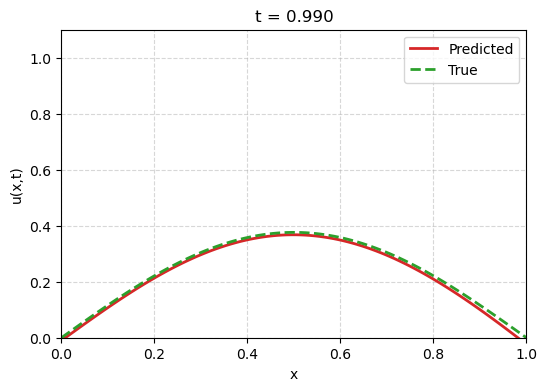

In [5]:
# Load all CSV files
files = sorted([f for f in os.listdir(data_dir) if f.startswith('data_') and f.endswith('.csv')])
nt = len(files) - 1  # Exclude initial condition

# Load spatial grid
x = pd.read_csv(os.path.join(data_dir, files[1]))["x"].values

# Time values and true solutions
time_array = np.zeros((nt,))
true_solutions = []

for i, file in enumerate(files[1:]):
    df = pd.read_csv(os.path.join(data_dir, file))
    time_array[i] = df["t"].iloc[0]
    u_true = df.filter(like='u_t').values.flatten()
    true_solutions.append(u_true)

true_solutions = np.array(true_solutions)

# Prepare figure
fig, ax = plt.subplots(figsize=(6,4))
line_pred, = ax.plot([], [], lw=2, color='tab:red', label='Predicted')
line_true, = ax.plot([], [], lw=2, color='tab:green', linestyle='--', label='True')
ax.set_xlim(x.min(), x.max())
ax.set_ylim(0, 1.1)
ax.set_xlabel("x")
ax.set_ylabel("u(x,t)")
title = ax.set_title("")
ax.grid(linestyle='--', alpha=0.5)
ax.legend()

# Update function
def update(frame):
    t_val = time_array[frame]
    t_input = np.full_like(x, fill_value=t_val)

    u_pred = model_ini.predict(x, t_input).numpy().flatten()
    u_true = true_solutions[frame]

    line_pred.set_data(x, u_pred)
    line_true.set_data(x, u_true)
    title.set_text(f"t = {t_val:.3f}")

# Directory for saving PNGs
png_dir = "/Users/pushpita/Documents/ML Projects/Project3/plot/animations/PINN/frames_png"
os.makedirs(png_dir, exist_ok=True)

# Generate and save frames
for frame in range(nt):
    update(frame)
    fname = os.path.join(png_dir, f"frame_{frame:04d}.png")
    plt.savefig(fname, dpi=110, bbox_inches="tight")